In [4]:
import os
import numpy as np
import numba as nb
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib


### Define function here

In [5]:
def name_encoding(table = 'click_order_user.csv', window_r = 2):
    '''
    generate output filename by input filename
    
    input:
    ------------
    table: str
        input table name
    window_r: int
        ridus of windows. Window size = 2 * window_r + 1
    
    output:
    ------------
    n_gram_table_name: str
        name of n gram csv file
        
    example:
    ------------
    >>> name_encoding(table = 'click_order_user.csv', window_r = 2)
    user_5_gram.csv
    
    '''
    name = table.replace('.csv', '').split('_')[-1]
    return '_'.join([name, str(2*window_r+1), 'gram']) + '.csv'


def command_pipeline(command):
    '''
    execute a sequence of os command
    
    input:
    ------------
    command: multiple line string
        each line is a os command
        
    example:
    ------------
    >>> command = """
    cd ./data
    data_preprocessing.exe
    >>> command_pipeline(command)
    """
    
    '''
    with open('command_pipeline_temp.bat', 'w') as f:
        f.write(command)
    os.system("command_pipeline_temp.bat")
    os.remove("command_pipeline_temp.bat")
    
def create_order_column(rowData):
    '''
    generate buy column from n gram csv
    '''
    for data in rowData:
        if data == "NONE":
            continue
        if data.split('__')[-2] == "True":
            return data
    return "NONE"


def save_model(obj, filepath):
    with open(filepath, 'wb') as f:
        joblib.dump(obj, f)
        
        
def negative_sampling(l):
    '''
    negative sampling, input number of classes, output function to do negative sampling
    
    input:
    ---------
    l: int
        number of classes
    
    output:
    ---------
    sampling: function of sample
    '''
    def sampling(rowData):
        rowData = np.array(rowData)
        negative_sample = np.random.choice(l)
        while negative_sample in rowData:
            negative_sample = np.random.choice(l)
        return negative_sample
    return sampling


## 1. Preprocessing
### 1.1 Specify arguments and configuration 

In [6]:
# ridus for n-gram window
WINDOW_R = 2
NUM_NEGATIVE = 4

DATA_PATH = "./data/" # path to store data
USER_TABLE_NAME = 'click_order_user.csv'
USER_N_GRAM_TABLE_NAME = name_encoding(USER_TABLE_NAME, WINDOW_R) # name of output n-gram file

SKU_TABLE_NAME = 'click_order_sku.csv'
SKU_N_GRAM_TABLE_NAME = name_encoding(SKU_TABLE_NAME, WINDOW_R) # name of output n-gram file


print('output n gram data into: ', USER_N_GRAM_TABLE_NAME, SKU_N_GRAM_TABLE_NAME)

output n gram data into:  user_5_gram.csv sku_5_gram.csv


### 1.2 preprocessing

1. join tables, then sort by sku_ID or user_ID
2. preprocessing using data_preprocessing.exe

In [57]:
preprocessing_command_user = """
python table_join.py
cd ./data
data_preprocessing.exe {0} sku_ID {1} {2} user_level gender education city_level purchase_power marital_status age if_order
cd ..
""".format(WINDOW_R, USER_TABLE_NAME, USER_N_GRAM_TABLE_NAME)

preprocessing_command_sku = """
cd ./data
data_preprocessing.exe {0} user_ID {1} {2} sku_ID if_order
cd ..
""".format(WINDOW_R, SKU_TABLE_NAME, SKU_N_GRAM_TABLE_NAME)





if not os.path.exists(DATA_PATH+N_GRAM_TABLE_NAME):
    command_pipeline(preprocessing_command_user)

### 1.2.1 user_encoding

In [86]:
user_5_gram = pd.read_csv('./data/user_5_gram.csv', header=None)
user_5_gram.head(5)

,0,1,2,3,4
0,NONE,NONE,4__M__3__2__2__S__26-35__,3__M__2__2__2__M__26-35__,2__F__1__1__2__M__36-45__
1,NONE,4__M__3__2__2__S__26-35__,3__M__2__2__2__M__26-35__,2__F__1__1__2__M__36-45__,NONE
2,4__M__3__2__2__S__26-35__,3__M__2__2__2__M__26-35__,2__F__1__1__2__M__36-45__,NONE,NONE
3,NONE,NONE,1__F__-1__-1__-1__U__16-25__,NONE,NONE
4,NONE,NONE,4__M__4__2__2__S__26-35__,1__U__-1__-1__-1__U__U__,NONE


### 1.2.2 label encoding

In [4]:
if not os.path.exists("./models/5_gram_user_label_encoder.pk"):
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(np.array(user_5_gram).flatten())

    save_model(label_encoder, "./models/5_gram_user_label_encoder.pk")
else:
    label_encoder = joblib.load("./models/5_gram_user_label_encoder.pk")

C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [113]:
user_5_gram = user_5_gram.apply(label_encoder.transform)
user_5_gram.head(10)

,0,1,2,3,4
0,7762,7762,7468,5897,2666
1,7762,7468,5897,2666,7762
2,7468,5897,2666,7762,7762
3,7762,7762,71,7762,7762
4,7762,7762,7664,2148,7762
5,7762,7664,2148,7762,7762
6,7762,7762,948,2148,4574
7,7762,948,2148,4574,3255
8,948,2148,4574,3255,7761
9,2148,4574,3255,7761,993


### 1.2.3 Negative sampling

In [143]:
num_classes_ = len(label_encoder.classes_)
for i in range(NUM_NEGATIVE):
    
    user_5_gram['nega_sample_' + str(i)] = user_5_gram.iloc[:, :5].apply(negative_sampling(num_classes_), axis = 1)
    
user_5_gram.head(15)

,0,1,2,3,4,nega_sample_0,nega_sample_1,nega_sample_2,nega_sample_3
0,7762,7762,7468,5897,2666,3091,7209,6728,7623
1,7762,7468,5897,2666,7762,4913,5457,799,3490
2,7468,5897,2666,7762,7762,5541,5148,7115,7718
3,7762,7762,71,7762,7762,1154,5509,6756,7543
4,7762,7762,7664,2148,7762,2928,1628,1120,3331
5,7762,7664,2148,7762,7762,1557,4865,1480,999
6,7762,7762,948,2148,4574,68,4457,7689,1482
7,7762,948,2148,4574,3255,4848,7192,1203,4849
8,948,2148,4574,3255,7761,6834,4378,3854,1107
9,2148,4574,3255,7761,993,375,2356,2264,5900


In [145]:
user_5_gram.to_csv('./data/user_5_gram_for_word2vec.csv', index=None)

## 2 Sequence to Vector model training

In [1]:
import os 

from models import sequence2vector
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.externals import joblib

tf.config.list_physical_devices()

C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# load n gram data
# convert n-gram data into training data
label_encoder = joblib.load("./models/5_gram_user_label_encoder.pk")

user_5_gram = pd.read_csv('./data/user_5_gram_for_word2vec.csv', index_col=None)
user_5_gram.head()

# split data into center, context and negative according to API
x_center = np.array(user_5_gram['2']).reshape(-1,1)
x_context = np.array(user_5_gram[['0', '1', '3', '4']])
x_negative = np.array(user_5_gram.iloc[:, -NUM_NEGATIVE:])
null_y = np.ones(len(x_center))

n_items = len(label_encoder.classes_)
data_size = len(x_center)

In [11]:
# Initialize sequence2vector model
# compile model

user2vec = sequence2vector.Sequence2Vector(n_items, 50)
user2vec.compile(optimizer='adam', loss = sequence2vector.negative_log_likelihood)

In [12]:
user2vec.fit([x_center, x_context, x_negative], null_y,
             validation_split = 0.3,shuffle=True,
             batch_size=512, epochs=3)

Tensor("sequence2_vector_2/binomial_probability_2/Log:0", shape=(None, 8, None, 1), dtype=float32)
(None, 8, None, 1)
Train on 3031777 samples, validate on 1299334 samples
Epoch 1/3
Tensor("sequence2_vector_2/binomial_probability_2/Log:0", shape=(None, 8, None, 1), dtype=float32)
(None, 8, None, 1)


C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tensor("sequence2_vector_2/binomial_probability_2/Log:0", shape=(None, 8, None, 1), dtype=float32)
(None, 8, None, 1)
3029504/3031777 [============================>.] - ETA: 0s - loss: 0.5910Tensor("sequence2_vector_2/binomial_probability_2/Log:0", shape=(None, 8, None, 1), dtype=float32)
(None, 8, None, 1)
3031777/3031777 [==============================] - 28s 9us/sample - loss: 0.5910 - val_loss: 0.5926
Epoch 2/3
3031777/3031777 [==============================] - 27s 9us/sample - loss: 0.5889 - val_loss: 0.5928
Epoch 3/3
3031777/3031777 [==============================] - 27s 9us/sample - loss: 0.5889 - val_loss: 0.5927


In [106]:
user2vec.save_weights('./models/5_gram_user2vec_weight.h5')
#user2vec.save('./models/5_gram_user2vec.h5')

## 3  Visualization of user2Vector

Import necessary library

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
user_vectors = pd.DataFrame() # 初始化dataframe
user_vectors['user'] = label_encoder.classes_ # 将user列设置为所有的users
user_vectors['user_encoding'] = user_vectors['user'].apply(lambda x: label_encoder.transform([x])) # 将user列encoding

user_vectors.head()

,user,user_encoding
0,-1__F__-1__1__-1__U__16-25__,[0]
1,-1__F__-1__1__-1__U__26-35__,[1]
2,-1__F__-1__2__-1__U__26-35__,[2]
3,-1__F__-1__2__-1__U__46-55__,[3]
4,-1__F__3__1__2__M__26-35__,[4]
...,...,...
7758,4__M__4__5__3__M__26-35__,[7758]
7759,4__M__4__5__3__M__36-45__,[7759]
7760,4__M__4__5__3__S__26-35__,[7760]
7761,4__U__-1__-1__-1__U__U__,[7761]


In [26]:
user_vectors['vector'] = user_vectors['user_encoding'].apply(user2vec.to_vector) # 将user转为vector
user_vectors.index = user_vectors['user'] # 设置user为index
vectors = user_vectors['vector'].apply(lambda x: np.array(x).flatten()) # 将tf.Tensor转为np.ndarray，并且设置为一维

user_vectors = pd.DataFrame(vectors.to_dict()).T

In [27]:
user_vectors

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
-1__F__-1__1__-1__U__16-25__,-0.028204,0.028447,-0.028205,-0.028065,-0.028167,-0.028388,-0.028128,0.028147,0.028249,-0.028222,...,0.028161,-0.027970,-0.028304,-0.028607,0.028241,0.028260,-0.028409,-0.028236,0.028314,-0.028295
-1__F__-1__1__-1__U__26-35__,-0.018095,0.018242,-0.018096,-0.018012,-0.018073,-0.018206,-0.018050,0.018061,0.018123,-0.018106,...,0.018070,-0.017954,-0.018156,-0.018338,0.018118,0.018129,-0.018219,-0.018115,0.018162,-0.018151
-1__F__-1__2__-1__U__26-35__,-0.020700,0.020896,-0.020702,-0.020589,-0.020671,-0.020848,-0.020640,0.020655,0.020737,-0.020715,...,0.020666,-0.020512,-0.020781,-0.021025,0.020731,0.020746,-0.020865,-0.020726,0.020789,-0.020774
-1__F__-1__2__-1__U__46-55__,-0.017078,0.017269,-0.017079,-0.016968,-0.017049,-0.017223,-0.017018,0.017034,0.017113,-0.017092,...,0.017044,-0.016894,-0.017157,-0.017396,0.017108,0.017122,-0.017239,-0.017103,0.017165,-0.017150
-1__F__3__1__2__M__26-35__,-0.024008,0.024206,-0.024009,-0.023894,-0.023978,-0.024158,-0.023946,0.023962,0.024044,-0.024022,...,0.023973,-0.023817,-0.024089,-0.024337,0.024038,0.024054,-0.024175,-0.024034,0.024098,-0.024082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4__M__4__5__3__M__26-35__,-0.020521,0.020729,-0.020523,-0.020403,-0.020490,-0.020679,-0.020457,0.020473,0.020560,-0.020537,...,0.020485,-0.020322,-0.020607,-0.020867,0.020553,0.020570,-0.020696,-0.020548,0.020616,-0.020600
4__M__4__5__3__M__36-45__,-0.015440,0.015634,-0.015441,-0.015329,-0.015410,-0.015587,-0.015379,0.015395,0.015476,-0.015454,...,0.015406,-0.015253,-0.015520,-0.015763,0.015470,0.015485,-0.015604,-0.015465,0.015528,-0.015513
4__M__4__5__3__S__26-35__,-0.015066,0.015180,-0.015066,-0.015000,-0.015048,-0.015152,-0.015030,0.015039,0.015087,-0.015074,...,0.015046,-0.014956,-0.015113,-0.015255,0.015083,0.015092,-0.015162,-0.015080,0.015118,-0.015109
4__U__-1__-1__-1__U__U__,0.287225,-0.289858,0.287244,0.285720,0.286826,0.289222,0.286404,-0.286614,-0.287712,0.287418,...,-0.286766,0.284688,0.288312,0.291601,-0.287633,-0.287837,0.289447,0.287570,-0.288426,0.288218


### 3.1.2 Dimension reduction with T-sne

In [28]:
tsne = TSNE(n_components=2)
vec_tsne = tsne.fit_transform(user_vectors)

In [73]:
df_tsne_color = pd.DataFrame()
df_tsne_color['user'] = user_vectors.index 
df_tsne_color = df_tsne_color['user'].str.split('__', expand=True)

df_tsne_color['x'] = vec_tsne[:,0]
df_tsne_color['y'] = vec_tsne[:,1]
df_tsne_color

,0,1,2,3,4,5,6,7,x,y
0,-1,F,-1,1,-1,U,16-25,,-91.033516,-9.853291
1,-1,F,-1,1,-1,U,26-35,,45.609009,42.260391
2,-1,F,-1,2,-1,U,26-35,,21.490326,0.207285
3,-1,F,-1,2,-1,U,46-55,,-13.929099,-19.909981
4,-1,F,3,1,2,M,26-35,,62.846436,-31.309250
...,...,...,...,...,...,...,...,...,...,...
7758,4,M,4,5,3,M,26-35,,27.833868,11.941881
7759,4,M,4,5,3,M,36-45,,7.165565,-74.364037
7760,4,M,4,5,3,S,26-35,,32.265717,-54.215397
7761,4,U,-1,-1,-1,U,U,,-2.828062,-27.052656


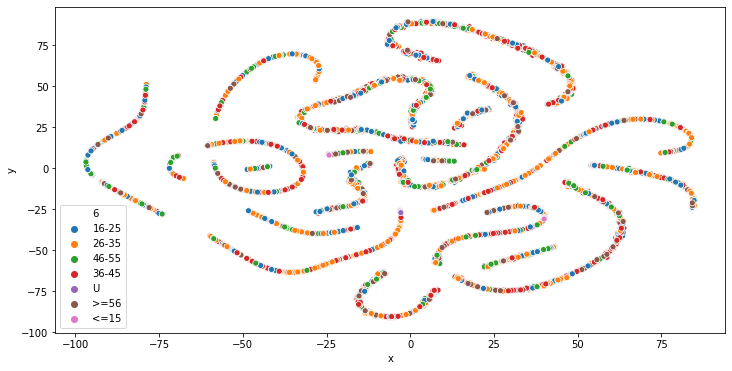

In [74]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='x', y='y', data=df_tsne_color, hue=6)

### 3.2 Cluster analysis with DBSCAN

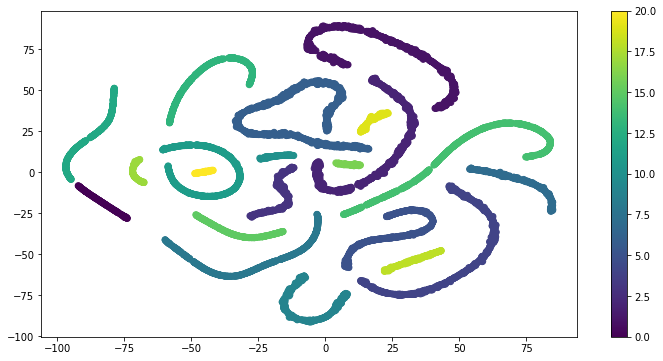

In [101]:
from sklearn.cluster import DBSCAN

cluster_model = DBSCAN(3.5)
user_cluster = cluster_model.fit_predict(vec_tsne)

df_tsne_color['cluster'] = user_cluster

plt.figure(figsize=(12, 6))
#sns.scatterplot(x='x', y='y', data=df_tsne_color, hue='cluster')
plt.scatter(df_tsne_color['x'], df_tsne_color['y'], c=df_tsne_color['cluster'])
plt.colorbar()

In [100]:
df_tsne_color.query("cluster==1")

,0,1,2,3,4,5,6,7,x,y,cluster
1,-1,F,-1,1,-1,U,26-35,,45.609009,42.260391,1
25,0,F,-1,3,4,S,26-35,,-5.936499,81.960136,1
31,0,F,2,1,2,S,>=56,,11.665242,87.076813,1
38,0,F,3,4,3,S,36-45,,46.752304,45.644703,1
43,0,M,3,4,2,S,36-45,,-6.308349,80.341965,1
...,...,...,...,...,...,...,...,...,...,...,...
7684,4,M,4,3,-1,U,26-35,,37.116283,70.251740,1
7688,4,M,4,3,1,M,46-55,,35.423191,70.549110,1
7736,4,M,4,4,3,S,26-35,,18.505423,84.416855,1
7747,4,M,4,5,1,S,16-25,,44.285316,61.902351,1


In [104]:
user_vectors.to_csv('./output/5_gram_user_vec.csv')
df_tsne_color.to_csv('./output/5_gram_user_vec_tsne_cluster.csv')